In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt

Then we import GODOT modules and create a universe from configuration.

The [universe](./universe2.yml) contains an entry to insert a keplerian orbit point, named 'SC' into the frames system.

In [10]:
from godot.core import tempo, astro, events
from godot import cosmos
from godot.model import eventgen

# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

# create the universe
uni_config = cosmos.util.load_yaml('universe2.yml')
uni = cosmos.Universe(uni_config)

In [11]:
for p in uni.frames.listPointNames():
    print(f"Frames contains point {p}") 

Frames contains point solarSystem_point
Frames contains point solarSystemGravity_point
Frames contains point GeoSat
Frames contains point New_Norcia_Two
Frames contains point MS12
Frames contains point MS11
Frames contains point DSS55
Frames contains point KO12
Frames contains point DSS36
Frames contains point Canberra_36
Frames contains point BEAR_LAKES
Frames contains point NN13
Frames contains point NN12
Frames contains point A11
Frames contains point APOLLO_11_LM
Frames contains point DSS24
Frames contains point DSS45
Frames contains point VL42
Frames contains point VL41
Frames contains point NN21
Frames contains point DSS42
Frames contains point Canberra_42
Frames contains point Canberra_34
Frames contains point NN22
Frames contains point DSS35
Frames contains point Canberra_35
Frames contains point Madrid_61
Frames contains point Kourou
Frames contains point MLX4
Frames contains point USUDA
Frames contains point Vilspa_1
Frames contains point NN11
Frames contains point VL21
Frame

In [12]:
for a in uni.frames.listAxesNames():
   print(f"Frames contains axes {a}")

Frames contains axes solarSystem_axes
Frames contains axes SC_LOF
Frames contains axes NNO2
Frames contains axes New_Norcia_Two
Frames contains axes MS11
Frames contains axes DSS55
Frames contains axes Madrid_54
Frames contains axes KO12
Frames contains axes Kiruna
Frames contains axes DSS36
Frames contains axes Canberra_36
Frames contains axes BEAR_LAKES
Frames contains axes NN13
Frames contains axes NN12
Frames contains axes A11
Frames contains axes APOLLO_11_LM
Frames contains axes DSS24
Frames contains axes DSS45
Frames contains axes VL42
Frames contains axes VL41
Frames contains axes Goldstone_24
Frames contains axes Vilspa_4
Frames contains axes DSS26
Frames contains axes DSS15
Frames contains axes MG12
Frames contains axes Goldstone_14
Frames contains axes Madrid_55
Frames contains axes DSS13
Frames contains axes Kourou
Frames contains axes MLX4
Frames contains axes DSS25
Frames contains axes Bear_Lakes
Frames contains axes Vilspa_2
Frames contains axes CB12
Frames contains axes

# Setup

We setup the universe as defined in the yml file.
Furthermore we define a timespan, here one month, evaluated in 30 seconds timesteps.

In [13]:
#Setup
uni_config = cosmos.util.load_yaml('universe2.yml')
uni = cosmos.Universe(uni_config)

# specify a time grid
ep1 = tempo.Epoch('2026-04-01T00:00:00 TDB')
ep2 = tempo.Epoch('2026-05-01T00:00:00 TDB')
ran = tempo.EpochRange( ep1, ep2 )
grid = ran.createGrid(30.0) # 30 seconds stepsize
eps = 1e-6
tol = 1e-6
event_grid = ran.contract(eps).createGrid(30.0)

# Elevation of New Norcia w.r.t. Spacecraft

When wanting communication with a spacecraft orbiting the moon, there can be two objects interrupting - Earth and Moon.

The interruptions by the earth from Cebreros to SC can be modeled by finding the elevation. Everything below horizon (0 deg) is a block. For more certainty, we use 10 degrees. GODOT includes a Horizon mask for New Norcia, Cebreros ang Malargue, that could be used.

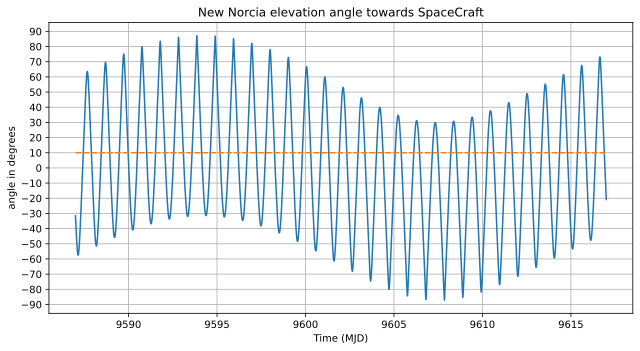

In [14]:
# get the time evaluable for the occulation distance of Mars by Earth
model = uni.evaluables["New_Norcia_Moon_Elevation"]
min_value = 10
fig = plt.figure(figsize=(9, 5))
plt.title('New Norcia elevation angle towards SpaceCraft')
plt.xlabel('Time (MJD)')
plt.ylabel('angle in degrees')
times = [time.mjd() for time in grid]
values = np.degrees([model.eval(time) for time in grid])
plt.plot(times, values)
plt.plot(times,[min_value]*len(times),'--')
plt.tight_layout()
plt.yticks(np.linspace(-90,90,19))
plt.grid(True)
plt.show()

# Event evaluation of Cebreros elevation with regards to Space craft - 10 degrees

Events are evaluated as
$$
g(t) > 0
$$

Event interval are evaluated as time periods where this is true

In [15]:
model = uni.evaluables["Cebreros_Moon_Elevation"]
min_value = np.radians(10) # horizon placed at 10 degrees
func = model - min_value

generator = eventgen.EventGenerator(func, eps, tol) # use negative to compute periods with no visibility
space_craft_within_elevation_CB = generator.computeEventIntervals(event_grid)
for interval in space_craft_within_elevation_CB:
    start = interval.start().value()
    end = interval.end().value()
    print( f"Spacecraft within elevetion from {start} to {end}, duration {end - start} secs" )

Spacecraft within elevetion from 2026-04-01T00:00:00.000001 TDB to 2026-04-01T04:34:57.709762 TDB, duration 16497.709761374495 secs
Spacecraft within elevetion from 2026-04-01T19:23:47.306893 TDB to 2026-04-02T04:53:48.824568 TDB, duration 34201.51767486295 secs
Spacecraft within elevetion from 2026-04-02T20:32:33.215409 TDB to 2026-04-03T05:12:59.256291 TDB, duration 31226.04088223072 secs
Spacecraft within elevetion from 2026-04-03T21:41:17.058587 TDB to 2026-04-04T05:33:49.917644 TDB, duration 28352.85905748656 secs
Spacecraft within elevetion from 2026-04-04T22:48:36.688022 TDB to 2026-04-05T05:57:50.289669 TDB, duration 25753.601647350708 secs
Spacecraft within elevetion from 2026-04-05T23:58:37.667010 TDB to 2026-04-06T06:26:58.685268 TDB, duration 23301.01825822677 secs
Spacecraft within elevetion from 2026-04-07T01:05:31.373367 TDB to 2026-04-07T07:03:42.635177 TDB, duration 21491.261809344345 secs
Spacecraft within elevetion from 2026-04-08T02:02:08.319098 TDB to 2026-04-08T07

# Moon obstruction of Spacecraft, as seen from Cerbreros

Besides the earth hiding, we want to know wether the moon blocks the view of the spacecraft. This can be done by calculating if the vector between the ground station and the SC intersects the surface of the moon. If the vector does, and the spacecraft is closer to the groundstation than the moon, it is still visible

In [ ]:
import godot.core.astro as astro 
import godot.core.events as events
import numpy as np
# Alias for Cebreros
groundStation = 'CB11'
def sphere_intersection(camera_pos, direction, radius = 1737.4):
    """Calculate the intersection of a vector from the camera position with a sphere."""
    direction = direction / np.linalg.norm(direction)  # Normalize direction
    b = 2 * np.dot(camera_pos, direction)
    c = np.dot(camera_pos, camera_pos) - radius**2
    discriminant = b**2 - 4 * c
    
    if discriminant < 0:
        return None  # No intersection
    t_1 = (-b - np.sqrt(discriminant))/2
    t_2 = (-b + np.sqrt(discriminant))/2

    t = t_1 if np.abs(t_1) < np.abs(t_2) else t_2     
    intersection = camera_pos + t * direction
    return intersection

def CBSCnotBlockedByMoon( epo ):
    # Vector from moon to ground station
    #t = time.perf_counter()
    GS = uni.frames.vector3('Moon', groundStation, 'ICRF', epo)
    # Vector from moon to space craft
    SC = uni.frames.vector3('Moon', 'SC', 'ICRF', epo)
    #print(f"Time 2 evaluate: {time.perf_counter() - t} s")
    #t = time.perf_counter()
    res = sphere_intersection(GS, GS-SC)
    #print(f"Time 2 intersect: {time.perf_counter() - t} s")
    if (res is None):
        return 1
    int_dist = np.sqrt(np.sum(np.power(GS - res,2)))
    sc_dist = np.sqrt(np.sum(np.power(GS - SC,2)))
    #print(f"Intersection distance: {int_dist}, spacecraft distance: {sc_dist}, closer?: {sc_dist < int_dist}")
    closer = sc_dist < int_dist
    if closer:
        return 1
    else:
        return -1
CB_SC_visible = events.generateEventIntervalSet(CBSCnotBlockedByMoon, eps, grid, tol)

# Overlap of visibilities

In [17]:
import godot
visible = godot.core.events.overlap(CB_SC_visible, space_craft_within_elevation_CB)
import godot.core.tempo as tempo

for interval in visible:
    start = interval.start().value()
    end = interval.end().value()
    print( f"View from {start} to {end}, duration {end - start} secs" )

View from 2026-04-01T00:00:00.000001 TDB to 2026-04-01T00:31:48.394929 TDB, duration 1908.394928353081 secs
View from 2026-04-01T01:20:01.698344 TDB to 2026-04-01T02:25:02.019918 TDB, duration 3900.3215743019628 secs
View from 2026-04-01T03:13:15.888183 TDB to 2026-04-01T04:18:17.686414 TDB, duration 3901.798231154996 secs
View from 2026-04-01T19:23:47.306893 TDB to 2026-04-01T19:25:15.605871 TDB, duration 88.29897761431442 secs
View from 2026-04-01T20:13:28.638611 TDB to 2026-04-01T21:18:31.400361 TDB, duration 3902.761750031119 secs
View from 2026-04-01T22:06:43.147567 TDB to 2026-04-01T23:11:45.082750 TDB, duration 3901.935182662222 secs
View from 2026-04-01T23:59:55.979003 TDB to 2026-04-02T01:04:57.891238 TDB, duration 3901.9122356806506 secs
View from 2026-04-02T01:53:08.521830 TDB to 2026-04-02T02:58:11.280497 TDB, duration 3902.7586661267214 secs
View from 2026-04-02T03:46:22.234477 TDB to 2026-04-02T04:51:26.557177 TDB, duration 3904.3226998648634 secs
View from 2026-04-02T20:

# Plotting

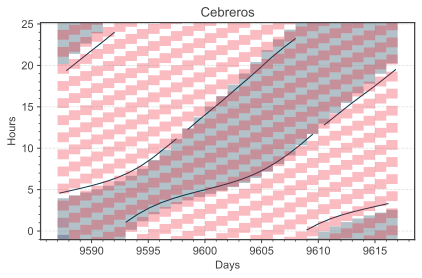

In [18]:
from godot.cosmos.show import Axes, Dimension

# Create axes of projection Time, Time

ax = Axes(projection=(Dimension.TIME, Dimension.TIME))

# Plot EventIntervalSets
ax.plot(space_craft_within_elevation_CB, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(CB_SC_visible, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(visible, hatch="////", add_borders=True, ls=":", facealpha = 1)

plt.xlabel("Days")
plt.ylabel("Hours")
plt.title('Cebreros')
plt.show()

Evaluated Elevation - 1.91e+00s
Evaluated intersection - 2.49e+01s
Gotten overlap - 1.36e-04s


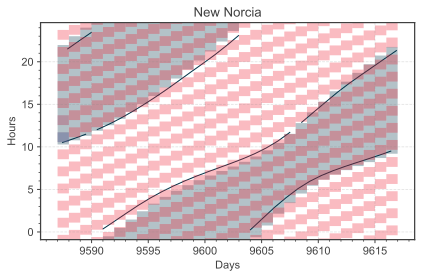

Plotted - 8.45e-01s


In [19]:
import time
ep1 = tempo.Epoch('2026-04-01T00:00:00 TDB')
ep2 = tempo.Epoch('2026-05-01T00:00:00 TDB')
ran = tempo.EpochRange( ep1, ep2 )

groundStation = 'NN11'
model = uni.evaluables["New_Norcia_Moon_Elevation"]
min_value = np.radians(10) # horizon placed at 10 degrees
func = model - min_value
generator = eventgen.EventGenerator(func, eps, tol) # use negative to compute periods with no visibility
event_grid = ran.contract(eps).createGrid(30.0)

t = time.perf_counter()
space_craft_within_elevation = generator.computeEventIntervals(event_grid)
print(f"Evaluated Elevation - {(time.perf_counter() - t):.2e}s")

t = time.perf_counter()
NN_SC_visible = events.generateEventIntervalSet(CBSCnotBlockedByMoon, eps, grid, tol)
print(f"Evaluated intersection - {(time.perf_counter() - t):.2e}s")

t = time.perf_counter()
visible = godot.core.events.overlap(NN_SC_visible, space_craft_within_elevation)
print(f"Gotten overlap - {(time.perf_counter() - t):.2e}s")

t = time.perf_counter()
# Create axes of projection Time, Time
ax = Axes(projection=(Dimension.TIME, Dimension.TIME))
# Plot EventIntervalSets
ax.plot(space_craft_within_elevation, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(NN_SC_visible, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(visible, hatch="////", add_borders=True, ls=":", facealpha = 1)
plt.title("New Norcia")
plt.xlabel("Days")
plt.ylabel("Hours")
plt.show()
print(f"Plotted - {(time.perf_counter() - t):.2e}s")

Evaluated Elevation
Evaluated intersection
Gotten overlap


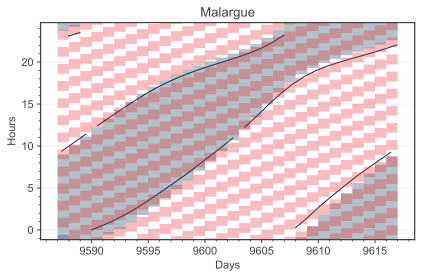

In [20]:
groundStation = 'MG11'
model = uni.evaluables["Malargue_Moon_Elevation"]
func = model - min_value
generator = eventgen.EventGenerator(func, eps, tol)
space_craft_within_elevation_MG = generator.computeEventIntervals(event_grid)
print("Evaluated Elevation")
MG_SC_visible = events.generateEventIntervalSet(CBSCnotBlockedByMoon, eps, grid, tol)
print("Evaluated intersection")
visible = godot.core.events.overlap(MG_SC_visible, space_craft_within_elevation_MG)
print("Gotten overlap")
# Create axes of projection Time, Time
ax = Axes(projection=(Dimension.TIME, Dimension.TIME))
# Plot EventIntervalSets
ax.plot(space_craft_within_elevation_MG, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(MG_SC_visible, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(visible, hatch="////", add_borders=True, ls=":", facealpha = 1)
plt.title('Malargue')
plt.xlabel("Days")
plt.ylabel("Hours")
plt.show()

In [21]:
starts = np.zeros_like(visible)
ends = np.zeros_like(visible)

for i, v in enumerate(visible):
    starts[i] = v.start().value()
    ends[i] = v.end().value()

visible_times = ends - starts 
invisible_times = starts[1:] - ends[:-1]  # Shifted to match the intervals before it
print("Spacecraft visible times from Malargue")
print("Visible time: Mean: {:.2f}s, Median: {:.2f}s, minimum: {:.2f}s, maximum: {:.2f}s".format(np.mean(visible_times),np.median(visible_times),np.min(visible_times),np.max(visible_times)))
print("Invisible time: Mean {:.2f}s, Median: {:.2f}s, minimum: {:.2f}s, maximum: {:.2f}s".format(np.mean(invisible_times),np.median(invisible_times),np.min(invisible_times),np.max(invisible_times)))
print("Mean visible percentage: {:.2f}%, Median visible percentage: {:.2f}%".format(np.mean(visible_times)/(np.mean(visible_times)+np.mean(invisible_times))*100,np.median(visible_times)/(np.median(visible_times)+np.median(invisible_times))*100))
print("Moon cycle time of medians: {:.2f}s, equivalent to {:.2f}m or {:.2f}h".format(np.median(visible_times)+np.median(invisible_times),(np.median(visible_times)+np.median(invisible_times))/60,(np.median(visible_times)+np.median(invisible_times))/3600))

Spacecraft visible times from Malargue
Visible time: Mean: 3528.24s, Median: 3906.58s, minimum: 112.35s, maximum: 3927.52s
Invisible time: Mean 11095.89s, Median: 2887.76s, minimum: 2869.17s, maximum: 70928.06s
Mean visible percentage: 24.13%, Median visible percentage: 57.50%
Moon cycle time of medians: 6794.35s, equivalent to 113.24m or 1.89h


GS elevations: 2026-04-01T00:00:00.000001 TDB to 2026-04-30T23:59:59.999999 TDB - 2591999.999998s
SC visible: 2026-04-01T00:00:00.000000 TDB to 2026-04-01T00:31:58.411534 TDB - 1918.4115343010099s
SC visible: 2026-04-01T01:19:55.556230 TDB to 2026-04-01T02:25:12.173987 TDB - 3916.617756829034s
SC visible: 2026-04-01T03:13:15.888183 TDB to 2026-04-01T04:18:28.568330 TDB - 3912.68014717097s
SC visible: 2026-04-01T05:06:32.501687 TDB to 2026-04-01T06:11:54.089652 TDB - 3921.587964867797s
SC visible: 2026-04-01T06:59:50.965333 TDB to 2026-04-01T08:05:17.640523 TDB - 3926.6751894239587s
SC visible: 2026-04-01T08:53:06.358195 TDB to 2026-04-01T09:58:38.220894 TDB - 3931.862699030076s
SC visible: 2026-04-01T10:46:24.769058 TDB to 2026-04-01T11:51:55.457301 TDB - 3930.6882427154346s
SC visible: 2026-04-01T12:39:46.281919 TDB to 2026-04-01T13:45:11.569221 TDB - 3925.2873017292413s
SC visible: 2026-04-01T14:33:10.293106 TDB to 2026-04-01T15:38:35.437923 TDB - 3925.1448167576764s
SC visible: 2026

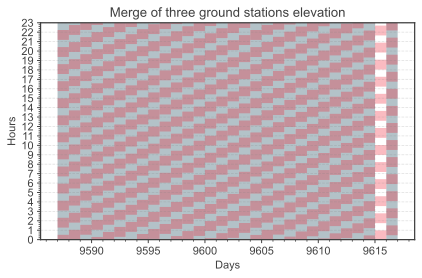

In [22]:
min_value = np.radians(10)
MME = uni.evaluables["Malargue_Moon_Elevation"]
MMEGen = eventgen.EventGenerator((MME-func), eps, tol)
MME_elev = MMEGen.computeEventIntervals(event_grid)

NNE = uni.evaluables["New_Norcia_Moon_Elevation"]
NNEGen = eventgen.EventGenerator((NNE-func), eps, tol)
NNE_elev = NNEGen.computeEventIntervals(event_grid)

CBE = uni.evaluables["Cebreros_Moon_Elevation"]
CBEGen = eventgen.EventGenerator((CBE-func), eps, tol)
CBE_elev = CBEGen.computeEventIntervals(event_grid)

gs_visible = godot.core.events.any((MME_elev, CBE_elev, NNE_elev))
sc_visible = godot.core.events.any((CB_SC_visible, NN_SC_visible, MG_SC_visible))

for int in gs_visible:
    print(f"GS elevations: {int.start().value()} to {int.end().value()} - {int.end().value()-int.start().value()}s")
for int in sc_visible:
    print(f"SC visible: {int.start().value()} to {int.end().value()} - {int.end().value()-int.start().value()}s")



print("Gotten overlap")
# Create axes of projection Time, Time
ax = Axes(projection=(Dimension.TIME, Dimension.TIME))
# Plot EventIntervalSets
ax.plot(gs_visible, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(sc_visible, add_borders=True, ls=":", facealpha = 0.05)
plt.yticks(np.arange(24))
plt.title('Merge of three ground stations elevation')
plt.xlabel("Days")
plt.ylabel("Hours")
plt.show()

# Visibility of SC from New Norcia over a year

In [23]:
import time
ep1 = tempo.Epoch('2026-04-01T00:00:00 TDB')
ep2 = tempo.Epoch('2027-04-01T00:00:00 TDB')
ran = tempo.EpochRange( ep1, ep2 )

groundStation = 'NN11'
model = uni.evaluables["New_Norcia_Moon_Elevation"]
min_value = np.radians(10) # horizon placed at 10 degrees
func = model - min_value
generator = eventgen.EventGenerator(func, eps, tol) # use negative to compute periods with no visibility
event_grid = ran.contract(eps).createGrid(30.0)

t = time.perf_counter()
space_craft_within_elevation = generator.computeEventIntervals(event_grid)
print(f"Evaluated Elevation - {(time.perf_counter() - t):.2e}s")

t = time.perf_counter()
NN_SC_visible = events.generateEventIntervalSet(CBSCnotBlockedByMoon, eps, event_grid, tol)
print(f"Evaluated intersection - {(time.perf_counter() - t):.2e}s")

t = time.perf_counter()
visible = godot.core.events.overlap(NN_SC_visible, space_craft_within_elevation)
print(f"Gotten overlap - {(time.perf_counter() - t):.2e}s")

Evaluated Elevation - 2.23e+01s
Evaluated intersection - 2.95e+02s
Gotten overlap - 9.90e-04s


<Figure size 6000x2000 with 0 Axes>

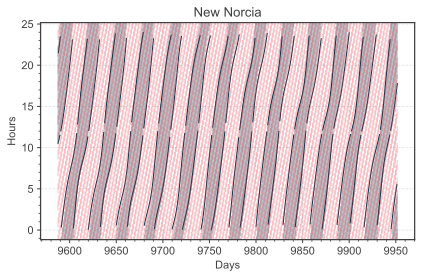

In [28]:
# Create axes of projection Time, Time
fig=plt.figure(figsize=(30,10), dpi= 200, facecolor='w', edgecolor='k')
ax = Axes(projection=(Dimension.TIME, Dimension.TIME))
# Plot EventIntervalSets
ax.plot(space_craft_within_elevation, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(NN_SC_visible, add_borders=True, ls=":", facealpha = 0.05)
ax.plot(visible, hatch="////", add_borders=True, ls=":", facealpha = 1)
plt.title("New Norcia")
plt.xlabel("Days")
plt.ylabel("Hours")
plt.show()

In [44]:
from godot.core import tempo, astro, events
from godot import cosmos
from godot.model import eventgen
from tqdm import tqdm



ep1 = tempo.Epoch('2026-04-01T00:00:00 TDB')
ep2 = tempo.Epoch('2027-04-01T00:00:00 TDB')
ran = tempo.EpochRange( ep1, ep2 )
epo = ran.contract(eps).createGrid(5.0)
groundStation = 'NN11'
GS = []
for t in tqdm(epo):
    GS.append(uni.frames.vector3('Moon', groundStation, 'ICRF', t))


100%|██████████| 6307201/6307201 [00:41<00:00, 152152.32it/s]
